In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import bayesflow as bf

from amortizer import amortizer
from src.models.HmmEam import model, constrain_parameters

from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

from pandas import read_csv

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_100.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
stan_model = CmdStanModel(stan_file="../../stan/hmm-eam.stan")

In [3]:
def configure_data(path):
    df = read_csv(path)
    df = np.array(df)
    df = df[:400,...]

    rts = df[:,1:2].astype(np.float32)
    choice = np.abs(df[:,2]-3)
    responses = tf.one_hot(choice-1, 2)

    summary_conditions = tf.concat([rts, responses], axis=-1)
    summary_conditions = tf.expand_dims(summary_conditions, axis=0)

    output = {
        "posterior_inputs": {
            "summary_conditions": summary_conditions
        },
        "mixture_inputs": {
            "summary_conditions": summary_conditions
        },
        "stan_inputs": {
            "n_obs": len(rts),
            "y": [(int(c), r) for c, r in zip(choice, rts[:,0])]
        },
        "rt": rts[:,0],
        "choice": choice
    }
    return output

In [4]:
df = configure_data("data-dutilh/subject-d.csv")

In [5]:
bf_unconstrained_posterior, (bf_forward, bf_backward, bf_smoothing) = amortizer.sample(df, n_samples=4000)
bf_unconstrained_posterior = bf_unconstrained_posterior[0]
bf_forward = bf_forward[0]
bf_backward = bf_backward[0]
bf_smoothing = bf_smoothing[0]
rts = df['posterior_inputs']['summary_conditions'][...,0]

bf_posterior = constrain_parameters(bf_unconstrained_posterior, rts)

In [6]:
stan_fit = stan_model.sample(df['stan_inputs'], adapt_delta=0.99, show_progress=False, inits=0)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpzdnv7yp8/hmm-eamfw187xwd/hmm-eam-20240826092205_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpzdnv7yp8/hmm-eamfw187xwd/hmm-eam-20240826092205_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpzdnv7yp8/hmm-eamfw187xwd/hmm-eam-20240826092205_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpzdnv7yp8/hmm-eamfw187xwd/hmm-eam-20240826092205_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
stan_posterior = np.array([
    stan_fit.stan_variables()['transition_matrix'][:, 0, 0],
    stan_fit.stan_variables()['transition_matrix'][:, 1, 1],
    stan_fit.stan_variables()['alpha_1'],
    stan_fit.stan_variables()['alpha_2'],
    stan_fit.stan_variables()['nu_1'],
    stan_fit.stan_variables()['nu_2'][:,0],
    stan_fit.stan_variables()['nu_2'][:,1],
    stan_fit.stan_variables()['tau'],

]).transpose()

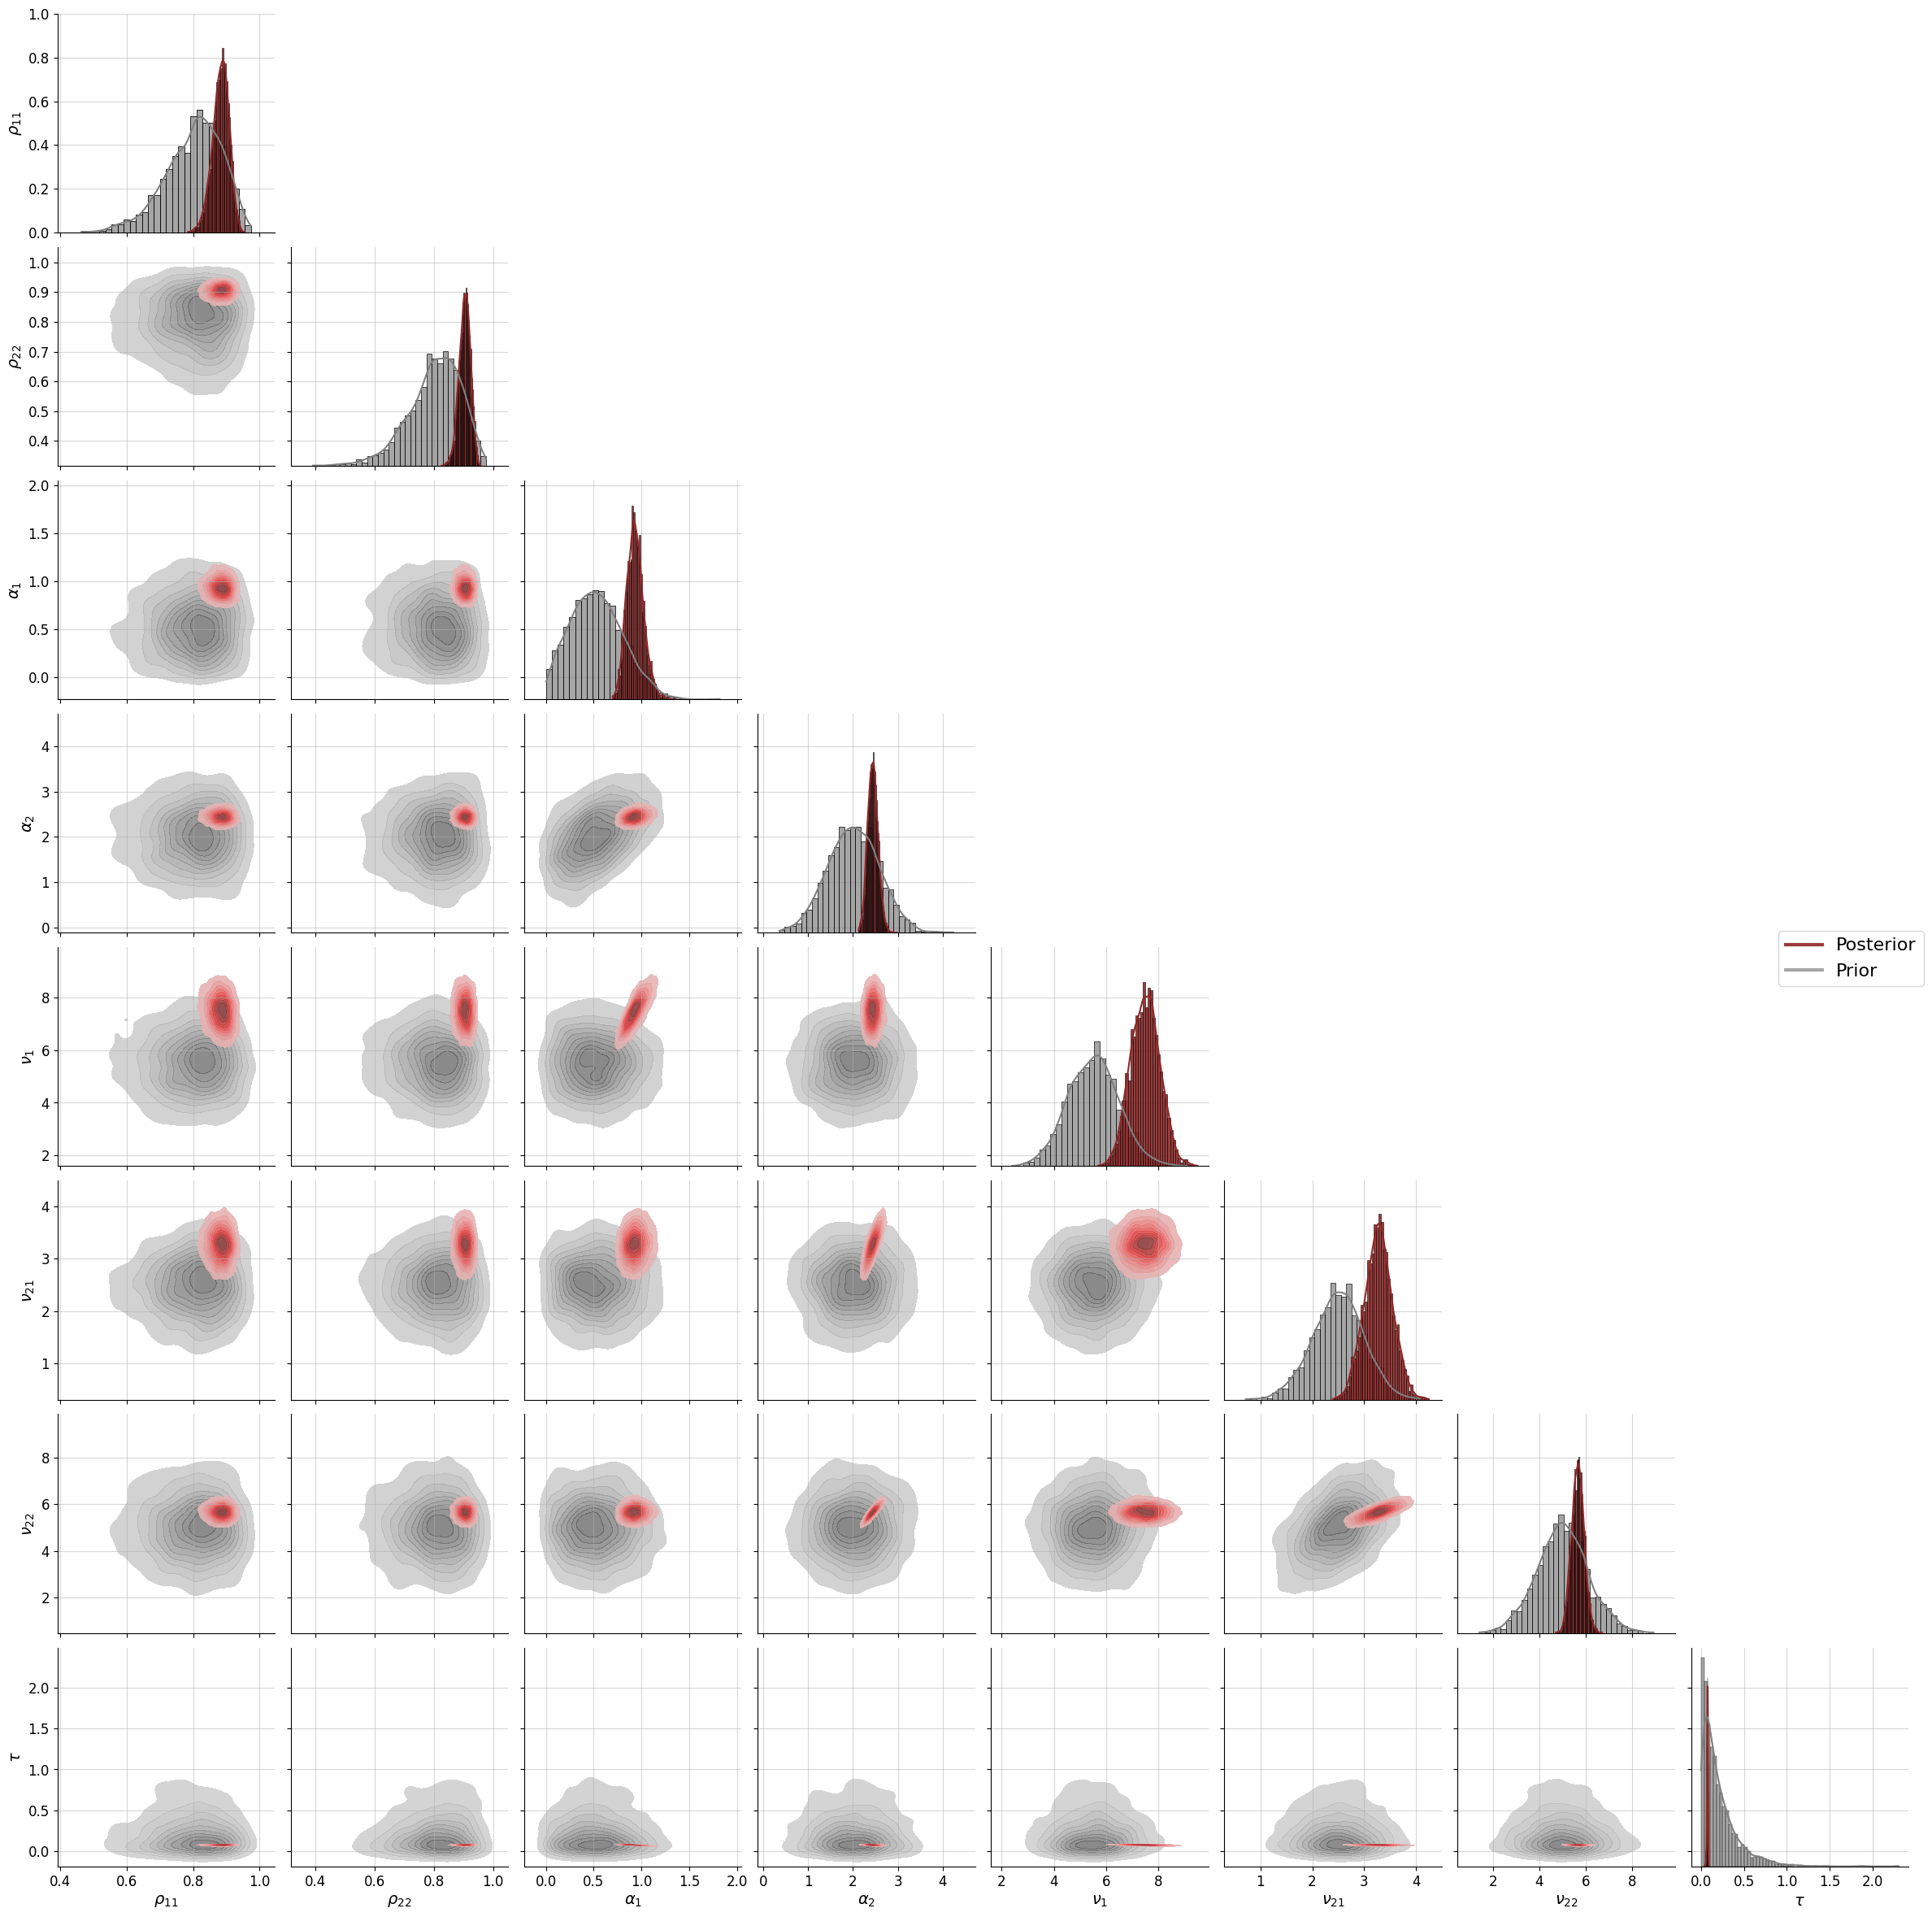

In [8]:
prior = model.prior(2000)['prior_draws']
f=bf.diagnostics.plot_posterior_2d(posterior_draws=stan_posterior, prior_draws=prior, param_names=model.param_names['constrained'])

In [9]:
stan_forward = stan_fit.stan_variables()["filtering"]
stan_smoothing = stan_fit.stan_variables()["smoothing"]

In [10]:
forward = np.array([bf_forward, stan_forward])
smoothing = np.array([bf_smoothing, stan_smoothing])

forward = np.quantile(forward, q = [0.005, 0.5, 0.995], axis=1)
smoothing = np.quantile(smoothing, q = [0.005, 0.5, 0.995], axis=1)

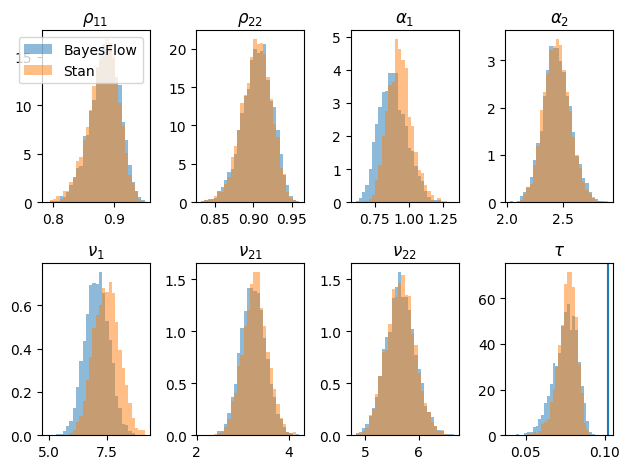

In [11]:
fig, axs = plt.subplots(ncols=4, nrows=2)
axs = axs.flatten()

bins = [
    np.linspace(np.min(bf_posterior[:,i]), np.max(bf_posterior[:,i]), 31) for i in range(8)
]
for i, par in enumerate(model.param_names['constrained']):
    axs[i].hist(bf_posterior[:,i], bins = bins[i], alpha=0.5, density=True, label = "BayesFlow")
    axs[i].hist(stan_posterior[:,i], bins = bins[i], alpha=0.5, density=True, label = "Stan")
    axs[i].set_title(par)

axs[-1].axvline(np.min(df['rt']))

axs[0].legend()
fig.tight_layout()

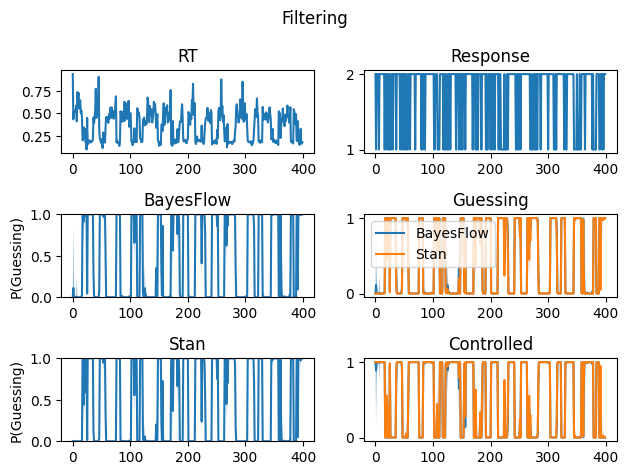

In [12]:
fig, axs = plt.subplots(3, 2)

axs[0, 0].set_title("RT")
axs[2, 1].set_title("Controlled")
axs[1, 0].set_title("BayesFlow")
axs[2, 0].set_title("Stan")
axs[0, 1].set_title("Response")
axs[1, 1].set_title("Guessing")

axs[0, 0].plot(df['rt'])
axs[0, 1].plot(df['choice'])

x = range(len(df['rt']))
for i, method in enumerate(['BayesFlow', 'Stan']):
    axs[i+1, 0].set_ylim([0,1])
    axs[i+1, 0].set_ylabel("P(Guessing)")
    axs[i+1, 0].plot(x, forward[1, i, :, 0])
    axs[i+1, 0].fill_between(x, forward[0, i, :, 0], forward[-1, i, :, 0], alpha = 0.5)
    for j, s in enumerate(['Guessing', 'Controlled']):
        axs[j+1, 1].plot(x, forward[1, i, :, j], label=method)
        axs[j+1, 1].fill_between(x, forward[0, i, :, j], forward[-1, i, :, j], alpha = 0.5)


axs[1,1].legend(loc='upper left')
f=fig.suptitle("Filtering")
fig.tight_layout()

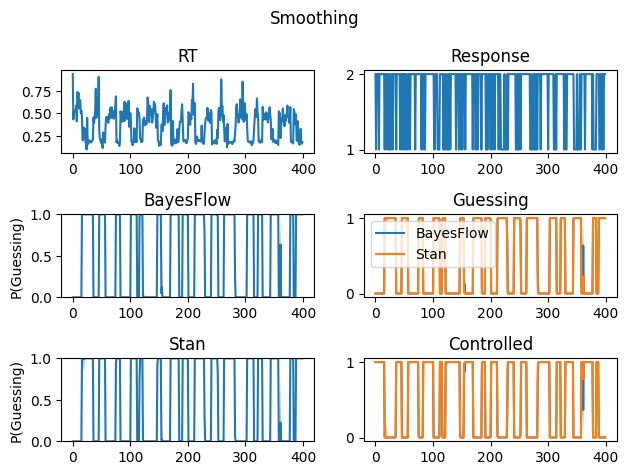

In [13]:
fig, axs = plt.subplots(3, 2)

axs[0, 0].set_title("RT")
axs[2, 1].set_title("Controlled")
axs[1, 0].set_title("BayesFlow")
axs[2, 0].set_title("Stan")
axs[0, 1].set_title("Response")
axs[1, 1].set_title("Guessing")

axs[0, 0].plot(df['rt'])
axs[0, 1].plot(df['choice'])

x = range(len(df['rt']))
for i, method in enumerate(['BayesFlow', 'Stan']):
    axs[i+1, 0].set_ylim([0,1])
    axs[i+1, 0].set_ylabel("P(Guessing)")
    axs[i+1, 0].plot(x, smoothing[1, i, :, 0])
    axs[i+1, 0].fill_between(x, smoothing[0, i, :, 0], smoothing[-1, i, :, 0], alpha = 0.5)
    for j, s in enumerate(['Guessing', 'Controlled']):
        axs[j+1, 1].plot(x, smoothing[1, i, :, j], label=method)
        axs[j+1, 1].fill_between(x, smoothing[0, i, :, j], smoothing[-1, i, :, j], alpha = 0.5)


axs[1,1].legend(loc='upper left')
fig.suptitle("Smoothing")
fig.tight_layout()

In [14]:
guessing = smoothing[1,1,:,0] > 0.5

In [15]:
np.mean(df['rt'][guessing])

0.22481756

In [16]:
np.mean(df['rt'][np.logical_not(guessing)])

0.4926057

In [17]:
np.std(df['rt'][guessing])

0.10063209

In [18]:
np.std(df['rt'][np.logical_not(guessing)])

0.10464832

In [19]:
# accuracy
np.mean(df['choice'][guessing])-1

0.5638297872340425

In [20]:
np.mean(df['choice'][np.logical_not(guessing)])-1

0.8867924528301887